In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import mediapipe as mp
from pathlib import Path
import time

In [2]:
hands = mp.solutions.hands.Hands(static_image_mode=True,
                                max_num_hands=1,
                                min_detection_confidence=0.5)

In [3]:
def clamp(x, y, size):
    x = max(0, min(x, size[1]))
    y = max(0, min(y, size[0]))
    return x,y

def get_bounding_box(landmark_values, image, pad_fraction = 0.2, pad_constant = 5):
    coord_list_x = []
    coord_list_y = []
    size = image.shape
    y_size, x_size, channels = size
    for landmark in landmark_values:
        coord_list_x.append(int(landmark.x * x_size))
        coord_list_y.append(int(landmark.y * y_size))
    x_min, x_max, y_min, y_max = min(coord_list_x), max(coord_list_x), min(coord_list_y), max(coord_list_y)
    x_pad, y_pad = pad_constant+int((x_max - x_min)*pad_fraction), pad_constant+int((y_max-y_min)*pad_fraction)
    top_left = clamp(x_min-x_pad, y_min-y_pad, size)
    bot_right = clamp(x_max+x_pad, y_max+y_pad, size)
    return image[top_left[1]:bot_right[1], top_left[0]:bot_right[0]]

def get_hand(filepath, warnings_list=[], pad_fraction = 0.2, pad_constant = 5):
    image = cv.flip(cv.imread(filepath), 1)
    results = hands.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    if not results.multi_hand_landmarks:
        print("Warning: hand not detected in image " + filepath)
        warnings_list.append(filepath)
        return None
    return cv.flip(get_bounding_box(results.multi_hand_landmarks[0].landmark._values, image, 
                            pad_fraction=pad_fraction, pad_constant=pad_constant), 1)

In [4]:
# script for batch processing a dataset which is in a folder with subfolders
# saves annotated images in temp/ with the same subfolder structure

def process_subfolders(datapath, image_function, file_extension = "", out_folder = "temp/", **kwargs):
    just_now = time.time()
    filecount = 0
    
    Path(out_folder).mkdir(exist_ok=True)
    for dir in Path(datapath).iterdir():
        Path(out_folder + dir.stem).mkdir(exist_ok=True)
        for file in dir.iterdir():
            if file.suffix.lower() not in ".jpg" + ".jpeg" + ".png" + file_extension:
                continue
            filepath = str(file)
            if not cv.haveImageReader(filepath):
                print("Error: Could not load " + filepath)
                continue
            filecount += 1   
            try:
                cv.imwrite(out_folder + dir.stem +"/"+ file.name, image_function(filepath, **kwargs))
            except:
                continue

    now = time.time()
    duration = now - just_now
    print("Elapsed time: " + str(duration))
    print("FPS: " + str(filecount/duration))

In [5]:
datapath = "Dataset (ur-garg)/"
pad_fraction = 0.2
pad_constant = 6
process_subfolders(datapath, get_hand, pad_fraction = pad_fraction, pad_constant = pad_constant)

Elapsed time: 172.42933440208435
FPS: 9.743121759563504


In [582]:
def rescale_square(image, size, 
                   upscale = cv.INTER_CUBIC,    # or cv.INTER_LINEAR, or others
                   downscale = cv.INTER_AREA,   # or cv.INTER_NEAREST, or others
                   blur = 'bilateral',          # or 'gauss' or 'none'
                   ksize = (5,5), sigmaX = 0,                  # defaults for Gaussian blur
                   d = 9, sigmaColor = 75, sigmaSpace = 75,    # detaults for bilateral blur
                   **kwargs):
    assert image.shape[0] == image.shape[1]
    
    if image.shape[0] > size:
        return cv.resize(image, (size,size), interpolation=downscale)
    elif image.shape[0] < size:
        ret = cv.resize(image, (size, size), interpolation = upscale)
        if blur.lower() == 'gauss':            
            return cv.GaussianBlur(ret,
                                   kwargs.pop('ksize', ksize),
                                   kwargs.pop('sigmaX', sigmaX),
                                   **kwargs)
        elif blur.lower() == 'bilateral':
            return cv.bilateralFilter(ret,
                                      kwargs.pop('d', d),
                                      kwargs.pop('sigmaColor',sigmaColor),
                                      kwargs.pop('sigmaSpace',sigmaSpace),
                                      **kwargs)
        return ret
    return image

rng = np.random.default_rng()

def square_and_rescale(image, target_size, fill_type = 'uniform', **kwargs):
    # the OpenCV functions require either float32 or uint8
    if image.dtype == 'float64':
        image = np.float32(image)   
    if len(image.shape) < 3:
        image = np.expand_dims(image, 2)
    y_size, x_size, channels = image.shape
    fill_size = 0
    if y_size > x_size:          
        fill_size = (y_size, y_size-x_size, channels)
    elif x_size > y_size:
        fill_size = (x_size-y_size, x_size, channels)
    if fill_size:
        if fill_type.lower() == 'uniform':
            fill = rng.random(size=fill_size, dtype=image.dtype)
        elif fill_type.lower() == 'gauss':
            fill = np.positive(rng.standard_normal(size=fill_size, dtype=image.dtype))
        elif fill_type.lower() == 'int':
            fill = rng.integers(0, 256, size=fill_size, dtype=image.dtype)
        else:
            fill = np.zeros(fill_size, dtype=image.dtype)
    coin_flip = rng.integers(0,1, endpoint=True)
    if y_size > x_size:
        if coin_flip:
            image = np.hstack([image, fill]) # could have these randomly do [fill, image] instead
        else:
            image = np.hstack([fill, image])
    elif x_size > y_size:       
        if coin_flip:
            image = np.vstack([image, fill])
        else:
            image = np.vstack([fill, image])
    # curiously some of the cv resize/blur functions can escape their proper ranges under some circumstances, so we clamp
    max_val = {'float32':1, 'uint8':255}[str(image.dtype)]
    return np.clip(rescale_square(image, target_size, **kwargs), 0, max_val)
    

In [574]:
grey_img=cv.imread("temp/A9.jpg",flags=0)

(91, 79)


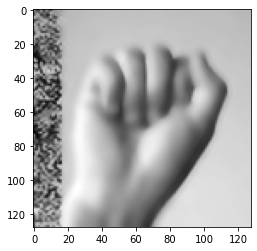

In [575]:
print(grey_img.shape)
plt.imshow(square_and_rescale(grey_img,128, fill_type='int'), 'gray')
plt.show()

In [576]:
img = cv.imread("temp/0.png")

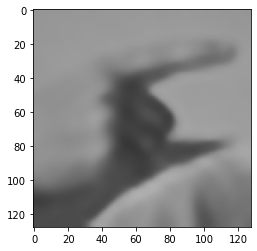

In [577]:
plt.imshow(square_and_rescale(img, 128))
plt.show()

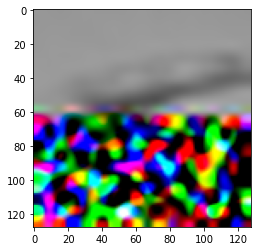

In [587]:
crop = np.float32(img[0:10,5:25])/255
newimg = square_and_rescale(crop, 128, fill_type='gauss', blur='gauss')
plt.imshow(newimg)
plt.show()

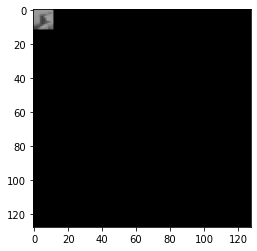

In [585]:
bigimg = np.zeros((300,300,3), dtype=np.uint8)
bigimg[0:28,0:28] = img

newimg = square_and_rescale(bigimg, 128)
plt.imshow(newimg)

Examples of an unexpected data augmentation technique: mixing images by averaging their pixel values. Even more surprising, they say it can work even better if you mix images with different labels! (The label of the resulting superposition is randomly chosen from those of its components.)

In [588]:
img1 = cv.cvtColor(cv.imread("temp/A9.jpg"), cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(cv.imread("temp/A8.jpg"), cv.COLOR_BGR2RGB)

In [589]:
img1 = np.float32(img1)/255
img2 = np.float32(img2)/255

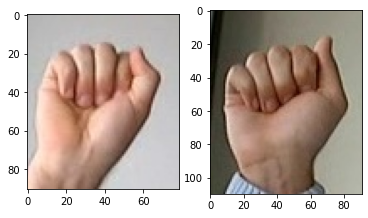

In [591]:
plt.subplot(1,2,1), plt.imshow(img1)
plt.subplot(1,2,2), plt.imshow(img2)
plt.show()

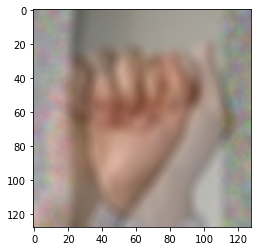

In [592]:
img3 = (square_and_rescale(img1, 128) +square_and_rescale(img2, 128))/2
plt.imshow(img3)
plt.show()

In [593]:
img1 = cv.imread('temp/11.png', flags=0)
img2 = cv.imread('temp/45.png', flags=0)

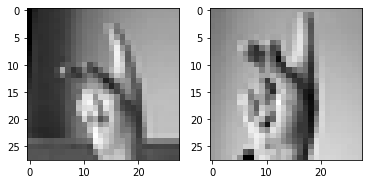

In [594]:
img1 = np.float32(img1)/255
img2 = np.float32(img2)/255
plt.subplot(1,2,1), plt.imshow(img1, 'gray')
plt.subplot(1,2,2), plt.imshow(img2, 'gray')
plt.show()

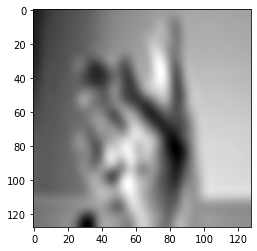

In [596]:
img3 = (square_and_rescale(img1, 128) +square_and_rescale(img2, 128))/2
plt.imshow(img3, 'gray')
plt.show()